## Preamble
Import necessary libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math
import numpy as np

from petsc4py import PETSc
from mpi4py import MPI

import ufl

import dolfinx
from dolfinx import fem, mesh
import dolfinx.fem.petsc

# print version (to search the right documentation)
print(f"DOLFINx version: {dolfinx.__version__}")

DOLFINx version: 0.9.0


## Problem definition
Define problem parameters and necessary data structures

In [2]:
# material parameters
rho = 1.
E = 1.
cel = math.sqrt(E/rho)

# spatial domain
L = 1.0

# time interval and time step
T0 = 2*L/cel # natural period
N0 = 5       # number of cycles
T = N0*T0
h = T0/500   # number of timesteps per cycle
nSteps = int(T/h)
times = np.linspace(0,T,nSteps+1)


In [6]:
# mesh and FE function space
nElems = 100
CFL = h*cel*nElems/L
print("CFL=",CFL)
domain = mesh.create_interval(MPI.COMM_WORLD,nElems,[0.0,L])
W = fem.functionspace(domain,("Lagrange",1,(2,)))

CFL= 0.4


In [7]:
# boundary conditions
fdim = domain.topology.dim - 1
boundary = mesh.locate_entities_boundary(domain,fdim, lambda x: np.full(x.shape[1], True, dtype=bool))
bc = fem.dirichletbc(np.zeros(2,dtype=PETSc.ScalarType), fem.locate_dofs_topological(W, fdim, boundary), W)


In [8]:
# initial condition
u_n = fem.Function(W)
u_n.name = "u_n"

V0 = 0.1
def initial_velocity_condition(x):
    return V0*np.sin(math.pi/L*x[0])
u_n.sub(1).interpolate(initial_velocity_condition)

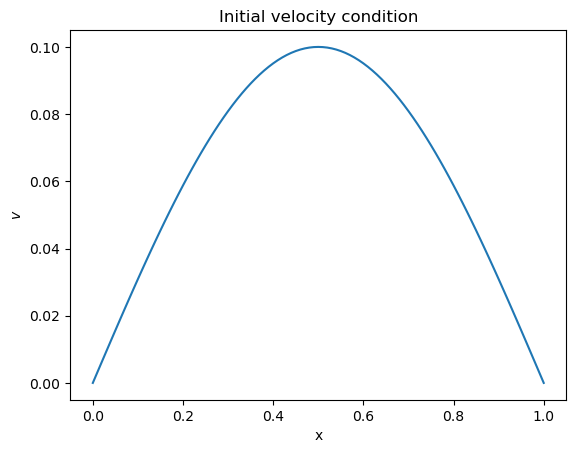

In [9]:
fig = plt.figure()
X = domain.geometry.x[:,0]
plt.xlabel('x')
plt.ylabel(r'$v$')
plt.title('Initial velocity condition')
plt.plot(X,u_n.x.array.reshape((-1,2))[:,1])

## Variational formulation
The continuous weak form is given by
$$\int_\Omega \rho \dot{v}\cdot w_v \,dx + \int_\Omega \nabla u \cdot E \cdot \nabla w_v \,dx 
  + \int_\Omega (\dot{u}-v) \cdot w_u \,dx
   = \int_\Omega f \cdot w_v \, dx$$
where $\rho$ is the density, $E$ the Young modulus, and $f$ are body forces.

After discretisation by a generalised mid-point scheme, it becomes
$$\int_\Omega \rho (v-v_n)\cdot w_v \,dx 
  + \int_\Omega h\, \nabla u_{n+\beta} \cdot E \cdot \nabla w_v \,dx 
  + \int_\Omega \left((u-u_n)-h\,v_{n+\beta}\right) \cdot w_u \,dx
  = \int_\Omega h f_{n+\beta} \cdot v \, dx$$
where $(u_n,v_n)$ is the solution at the beginning of the timestep, $u_{n+\beta}=(1-\beta)u_n+\beta u$, $v_{n+\beta}=(1-\beta)v_n+\beta v$ and $f_{n+\beta}=f(t_n+\beta h)$.
Algorithmic parameter $\beta$ is normally taken in the range $[0.5,1]$.

We can then rewrite the weak form as
$$\int_\Omega \rho v \cdot w_v \, dx + \int_\Omega \beta h \, \nabla u \cdot E \cdot \nabla w_v \,dx + \int_\Omega \left(u-\beta h v\right) \cdot w_u \,dx
  = \int_\Omega \rho v_n \cdot w_v \, dx + \int_\Omega (\beta-1) h \, \nabla u_n \cdot E \cdot \nabla w_v \,dx + \int_\Omega \left( u_n + (1-\beta) h v_n\right) \cdot w_u \, dx 
  + \int_\Omega h f_{n+\beta} \cdot w_v \, dx$$

In [10]:
# define reduced quadrature rule to produce lumped mass matrices
lumpM = False
if lumpM:
    dx1 = ufl.Measure("dx",domain=domain,metadata={"quadrature_rule":"GLL","quadrature_degree":1})
else:
    dx1 = ufl.dx

In [11]:
# algorithmic parameter and weak form
beta = 1.0

u = ufl.TrialFunction(W)
v = ufl.TestFunction(W)
f = fem.Constant(domain,PETSc.ScalarType(0))
a = rho * u[1]*v[1] * dx1 + beta*h * E * ufl.inner(ufl.grad(u[0]),ufl.grad(v[1])) * ufl.dx + (u[0]-beta*h*u[1])*v[0] * dx1
if (beta < 1.0):
    l = (rho * u_n[1] * v[1] + (u_n[0]+(1.0-beta)*h*u_n[1]) * v[0]) * dx1 \
        + (h*f * v[1] + (beta-1.0)*h * E*ufl.inner(ufl.grad(u_n[0]),ufl.grad(v[1]))) * ufl.dx
    # l = (rho * u_n[1] + h * f) * v[1] * ufl.dx + u_n[0] * v[0] * ufl.dx + (beta-1.0)*h * (E*ufl.inner(ufl.grad(u_n[0]),ufl.grad(v[1])) - u_n[1] * v[0]) * ufl.dx
else:
    l = (rho * u_n[1] * v[1] + u_n[0] * v[0]) * dx1  + h*f * v[1] * ufl.dx


## Time integration
We can integrate the solution over the given time interval. In each time step, we solve a linear problem. 

The matrix on the left-hand side (corresponding to the bilinear form) is constant and can be assembled once for all.
The right-hand side must be updated at each time step.

In [12]:
# create and assemble matrix
bilinear_form = fem.form(a)
A = fem.petsc.assemble_matrix(bilinear_form,bcs=[bc])
A.assemble()

# create RHS vector
linear_form = fem.form(l)
b = fem.petsc.create_vector(linear_form)

In [13]:
print(A.getValues(range(A.getSize()[0]),range(A.getSize()[1])))

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.00666667 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00666667 0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [14]:
# create linear solver
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

uh = fem.Function(W)
uh.name = "uh"

In [19]:
time = 0.0
U = np.zeros((nSteps+1,int(u_n.x.array.shape[0]/2)))
V = np.zeros((nSteps+1,int(u_n.x.array.shape[0]/2)))
U[0,:] = u_n.x.array.reshape((-1,2))[:,0]
V[0,:] = u_n.x.array.reshape((-1,2))[:,1]
for i in range(nSteps):
    time += h

    # update the RHS
    with b.localForm() as loc_b:
        loc_b.set(0.0)
    fem.petsc.assemble_vector(b,linear_form)

    # apply b.c. on vector
    fem.petsc.apply_lifting(b, [bilinear_form],[[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES,mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b,[bc])

    # solve linear problem
    solver.solve(b,uh.x.petsc_vec)
    uh.x.scatter_forward()

    # update solution
    u_n.x.array[:] = uh.x.array[:]
    U[i+1,:] = u_n.x.array.reshape((-1,2))[:,0]
    V[i+1,:] = u_n.x.array.reshape((-1,2))[:,1]

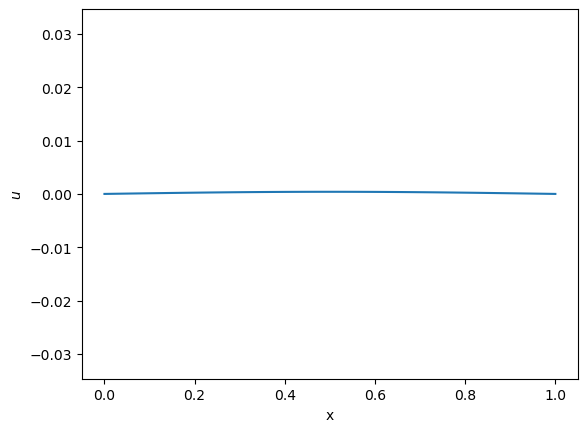

In [21]:
fig1 = plt.figure()
Umax = 1.1*np.max(U)
plt.ylim((-Umax,Umax))
plt.xlabel('x')
plt.ylabel(r'$u$')
line1, = plt.plot(X,u_n.x.array.reshape((-1,2))[:,0])

def update(frame):
    line1.set_ydata(U[frame+1])
    return line1
anim = animation.FuncAnimation(fig=fig1,func=update,frames=nSteps,interval=20)

from IPython.display import HTML
HTML(anim.to_html5_video())

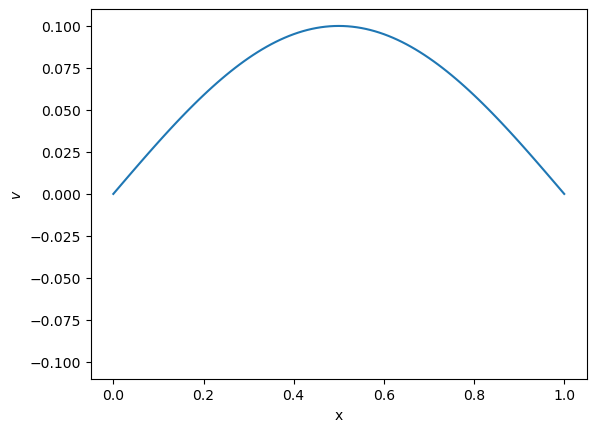

In [22]:
fig2 = plt.figure()
Vmax = 1.1*np.max(V)
plt.ylim((-Vmax,Vmax))
plt.xlabel('x')
plt.ylabel(r'$v$')
line2, = plt.plot(X,u_n.x.array.reshape((-1,2))[:,1])

def update(frame):
    line2.set_ydata(V[frame+1])
    return line2
anim = animation.FuncAnimation(fig=fig2,func=update,frames=nSteps,interval=20)

from IPython.display import HTML
HTML(anim.to_html5_video())

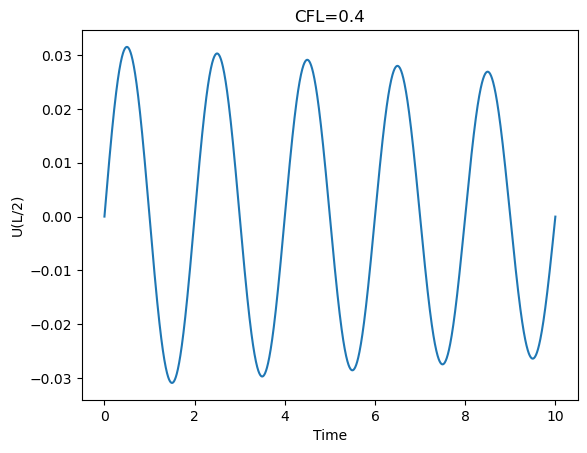

In [23]:
fig3 = plt.figure()
plt.title(f"CFL={CFL}")
plt.xlabel("Time")
plt.ylabel("U(L/2)")
plt.plot(times,U[:,int(nElems/2)])

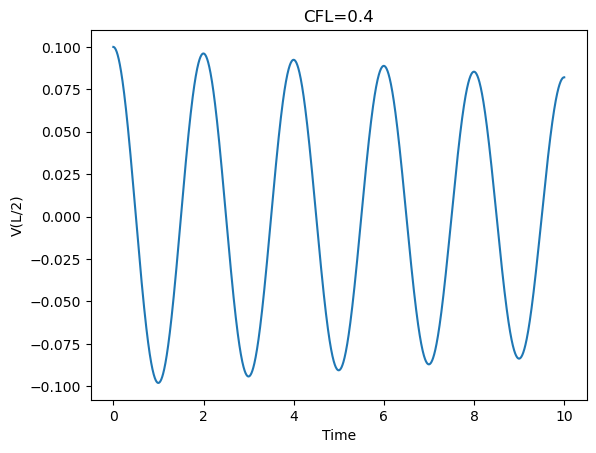

In [24]:
fig4 = plt.figure()
plt.title(f"CFL={CFL}")
plt.xlabel("Time")
plt.ylabel("V(L/2)")
plt.plot(times,V[:,int(nElems/2)])